# Walk Score

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandana as pdna
import networkx as nx
from shapely.geometry import LineString

### Inspecting the Child Care Centers dataset

In [2]:
# Let's check out the .shp file
child_care = gpd.read_file('raw_data/Child care centres.shp')
child_care.head()

,_id,LOC_ID,LOC_NAME,AUSPICE,ADDRESS,PCODE,ward,PHONE,bldg_type,BLDGNAME,IGSPACE,TGSPACE,PGSPACE,KGSPACE,SGSPACE,TOTSPACE,subsidy,run_date,geometry
0,1,1013,Lakeshore Community Child Care Centre,Non Profit Agency,101 SEVENTH ST,M8V 3B5,3,(416) 394-7601,Public Elementary School,Seventh Street Public School,0.0,20.0,32.0,52.0,60.0,164.0,Y,25NOV22,POINT (-79.50419 43.59992)
1,2,1014,Alternative Primary School Parent Group,Non Profit Agency,1100 SPADINA RD,M5N 2M6,8,(416) 322-5385,Public Elementary School,North Preparatory Public School,0.0,0.0,12.0,26.0,45.0,83.0,Y,25NOV22,POINT (-79.42037 43.70577)
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),Non Profit Agency,600 MORRISH RD,M1C 4Y1,25,(416) 287-0578,Catholic Elementary School,Cardinal Leger Catholic School,0.0,10.0,16.0,26.0,50.0,102.0,Y,25NOV22,POINT (-79.17546 43.79329)
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,Non Profit Agency,130 ADELAIDE ST W,M5H 3P5,10,(416) 415-2453,Other,None,10.0,15.0,40.0,0.0,0.0,65.0,Y,25NOV22,POINT (-79.38381 43.64969)
4,5,1017,Woodland Nursery School (Warden Woods Communit...,Non Profit Agency,1 FIRVALLEY CRT,M1L 1N8,20,(416) 694-1138x163,High Rise Apartment,None,0.0,10.0,16.0,0.0,0.0,26.0,Y,25NOV22,POINT (-79.28103 43.70295)


In [3]:
# Drop irrelevant columns
child_care.drop(columns = ['PCODE', 'AUSPICE', 'ward', 'PHONE', 'bldg_type', 'BLDGNAME', 'IGSPACE', 'TGSPACE', 
                   'PGSPACE', 'KGSPACE', 'SGSPACE', 'TOTSPACE', 'subsidy', 'run_date'], inplace = True)
child_care.head()

,_id,LOC_ID,LOC_NAME,ADDRESS,geometry
0,1,1013,Lakeshore Community Child Care Centre,101 SEVENTH ST,POINT (-79.50419 43.59992)
1,2,1014,Alternative Primary School Parent Group,1100 SPADINA RD,POINT (-79.42037 43.70577)
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),600 MORRISH RD,POINT (-79.17546 43.79329)
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,130 ADELAIDE ST W,POINT (-79.38381 43.64969)
4,5,1017,Woodland Nursery School (Warden Woods Communit...,1 FIRVALLEY CRT,POINT (-79.28103 43.70295)


In [4]:
# Just curious about the number of child care centers
len(child_care)

1055

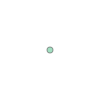

In [5]:
# What does a POINT() datum look like in a shapefile?
child_care['geometry'][0]

In [6]:
# The datatype is a shapely object
# It is important to remember that shapely objects can be points, lines, or polygons
type(child_care['geometry'][0])

shapely.geometry.point.Point

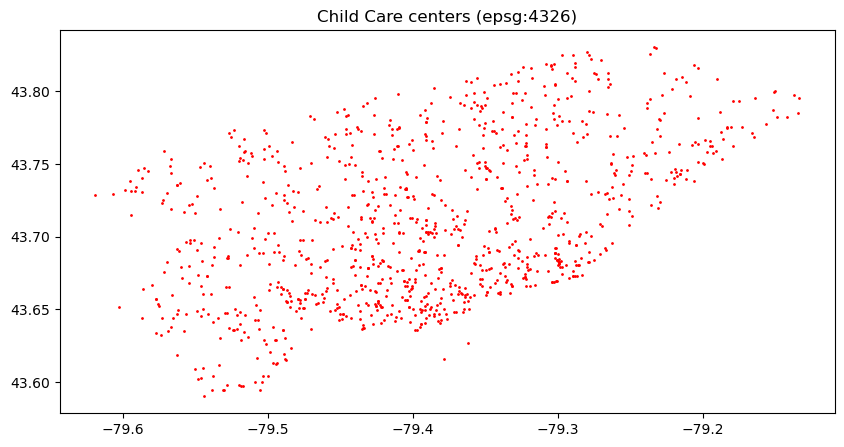

In [7]:
# Each shapely object is a point in space. Plotting the geopandas dataframe plots only the geometry column
# Each point represents a child care center in space. Already we can roughly see the shape of Toronto
ax = child_care.plot(figsize=(10, 10), color='red', markersize = 1)
ax.set_title('Child Care centers (epsg:4326)')
plt.show()

In [8]:
# Check the Coordinate Reference System out of curiosity
child_care['geometry'].crs

{'init': 'epsg:4326'}

In [9]:
# reprojecting epsg: 4326 to epsg:2019. This CRS seems to be preferable for the region of the earth we're representing
# See https://epsg.io/2019
# The bounds of representation are centered on Ontario
child_care = child_care.to_crs({'init': 'epsg:2019'})

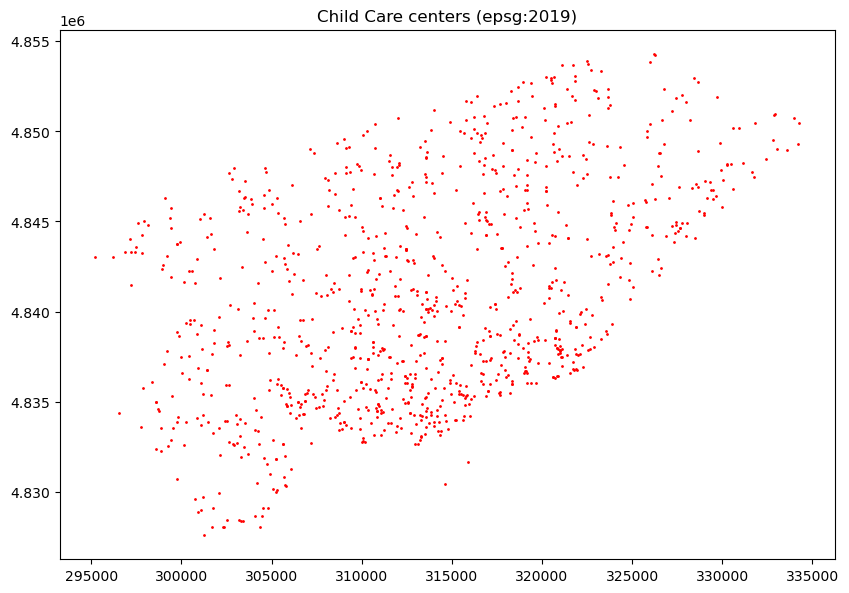

In [10]:
# After the reprojection the map seems like a more direct "top down" view
ax = child_care.plot(figsize=(10, 10), color='red', markersize = 1)
ax.set_title('Child Care centers (epsg:2019)')
plt.show()

In [11]:
# Isolate the longitude and lattitude numbers into x and y respectively
child_care['x'] = child_care.geometry.x
child_care['y'] = child_care.geometry.y
child_care.head()

,_id,LOC_ID,LOC_NAME,ADDRESS,geometry,x,y
0,1,1013,Lakeshore Community Child Care Centre,101 SEVENTH ST,POINT (304461.400 4828671.905),304461.400215,4.828672e+06
1,2,1014,Alternative Primary School Parent Group,1100 SPADINA RD,POINT (311217.446 4840433.213),311217.445605,4.840433e+06
2,3,1015,Cardinal Leger Child Care Centre (Scarborough),600 MORRISH RD,POINT (330918.335 4850204.630),330918.335077,4.850205e+06
3,4,1016,George Brown - Richmond Adelaide Childcare Centre,130 ADELAIDE ST W,POINT (314172.949 4834207.161),314172.948870,4.834207e+06
4,5,1017,Woodland Nursery School (Warden Woods Communit...,1 FIRVALLEY CRT,POINT (322448.989 4840140.901),322448.989348,4.840141e+06


### Load in Schools Data

In [12]:
# Column names didn't make it in
schools = gpd.read_file('raw_data/TCDSB - Schools.shp')
schools.head(3)

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,geometry
0,1,1,299,Annunciation,65 Avonwick Gt,North York,M3A 2M8,E,Open,POINT (-79.32127 43.75335)
1,2,2,290,All Saints,1435 Royal York Rd,Etobicoke,M9P 3A7,E,Open,POINT (-79.52716 43.68562)
2,3,3,222,St. Martin Program,55 Salisbury Ave,former Toronto,M4X 1C5,AL,Open,POINT (-79.36443 43.66717)


In [13]:
# Bring in .csv() file containing column names
school_column_names = pd.read_csv('raw_data/TCDSB - Schools_fields.csv')
school_column_names

,field,name
0,FIELD_1,_id
1,FIELD_2,OBJECTID
2,FIELD_3,TCDSB_CODE
3,FIELD_4,SCH_NAME
4,FIELD_5,ADDRESS_FULL
5,FIELD_6,MUNICIPALITY
6,FIELD_7,POSTAL_CODE
7,FIELD_8,TCDSB_LEVEL
8,FIELD_9,STATUS
9,geometry,geometry


In [14]:
# Fix the column names
mapper = dict(zip(list(school_column_names['field']), list(school_column_names['name'])))
schools.rename(mapper = mapper, axis = 1, inplace = True)
schools.columns = map(str.lower, schools.columns)
schools.head(3)

,_id,objectid,tcdsb_code,sch_name,address_full,municipality,postal_code,tcdsb_level,status,geometry
0,1,1,299,Annunciation,65 Avonwick Gt,North York,M3A 2M8,E,Open,POINT (-79.32127 43.75335)
1,2,2,290,All Saints,1435 Royal York Rd,Etobicoke,M9P 3A7,E,Open,POINT (-79.52716 43.68562)
2,3,3,222,St. Martin Program,55 Salisbury Ave,former Toronto,M4X 1C5,AL,Open,POINT (-79.36443 43.66717)


In [15]:
schools.crs

{'init': 'epsg:4326'}

In [16]:
schools = schools.to_crs({'init': 'epsg:2019'})
schools.crs

{'init': 'epsg:2019'}

In [17]:
schools.head(3)

,_id,objectid,tcdsb_code,sch_name,address_full,municipality,postal_code,tcdsb_level,status,geometry
0,1,1,299,Annunciation,65 Avonwick Gt,North York,M3A 2M8,E,Open,POINT (319193.656 4845732.133)
1,2,2,290,All Saints,1435 Royal York Rd,Etobicoke,M9P 3A7,E,Open,POINT (302610.050 4838192.207)
2,3,3,222,St. Martin Program,55 Salisbury Ave,former Toronto,M4X 1C5,AL,Open,POINT (315733.708 4836151.836)


### Bring in the Address Data for the city of Toronto

In [18]:
# reading municipal address point shape file
# https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/
# The One Address Repository data set provides a point representation for over 500,000 addresses within the City of Toronto.
address = gpd.read_file('raw_data/ADDRESS_POINT_WGS84.shp')
address.head()

,GEO_ID,LINK,MAINT_STAG,ADDRESS,LFNAME,LO_NUM,LONUMSUF,HINUM,HINUMSUF,ARC_SIDE,...,CLASS,NAME,X,Y,LONGITUDE,LATITUDE,OBJECTID,MUN_NAME,WARD_NAME,geometry
0,5729529,5729516,REGULAR,399,Lake Promenade,399,None,NaN,None,L,...,Land,None,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854300.947 5401738.297)
1,9950585,9950578,REGULAR,7,Hilo Rd,7,None,NaN,None,L,...,Land,None,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854393.601 5401944.461)
2,5729496,5729468,REGULAR,387,Lake Promenade,387,None,NaN,None,L,...,Land,None,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854243.981 5401777.244)
3,5729341,5729332,REGULAR,321,Lake Promenade,321,None,NaN,None,L,...,Land,None,301926.249,4827620.088,-79.535591,43.588517,1491594.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853861.166 5401982.195)
4,7304577,7304570,REGULAR,22,Thirty Sixth St,22,None,NaN,None,L,...,Land,None,301937.384,4827737.920,-79.535454,43.589578,1491597.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853845.885 5402145.216)


In [19]:
# That's a lot of columns. Many of these will be irrelevant for us
address.columns

Index(['GEO_ID', 'LINK', 'MAINT_STAG', 'ADDRESS', 'LFNAME', 'LO_NUM',
       'LONUMSUF', 'HINUM', 'HINUMSUF', 'ARC_SIDE', 'DISTANCE', 'FCODE',
       'FCODE_DES', 'CLASS', 'NAME', 'X', 'Y', 'LONGITUDE', 'LATITUDE',
       'OBJECTID', 'MUN_NAME', 'WARD_NAME', 'geometry'],
      dtype='object')

In [20]:
# change column names from upper to lower case
address.columns = map(str.lower, address.columns)

# Keep only columns that we may need.
address = address[['geo_id', 'maint_stag','address','lfname','x','y','longitude','latitude','objectid',
                   'mun_name','ward_name','geometry']]
address.head()

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,ward_name,geometry
0,5729529,REGULAR,399,Lake Promenade,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854300.947 5401738.297)
1,9950585,REGULAR,7,Hilo Rd,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854393.601 5401944.461)
2,5729496,REGULAR,387,Lake Promenade,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8854243.981 5401777.244)
3,5729341,REGULAR,321,Lake Promenade,301926.249,4827620.088,-79.535591,43.588517,1491594.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853861.166 5401982.195)
4,7304577,REGULAR,22,Thirty Sixth St,301937.384,4827737.920,-79.535454,43.589578,1491597.0,Etobicoke,Etobicoke-Lakeshore,POINT (-8853845.885 5402145.216)


In [21]:
# Check the CRS for this geodataframe's shapely objects (i.e. the records in the geometry column) against the child care centers
# All CRS should agree with each other
child_care['geometry'].crs, address['geometry'].crs

({'init': 'epsg:2019'}, {'init': 'epsg:3857'})

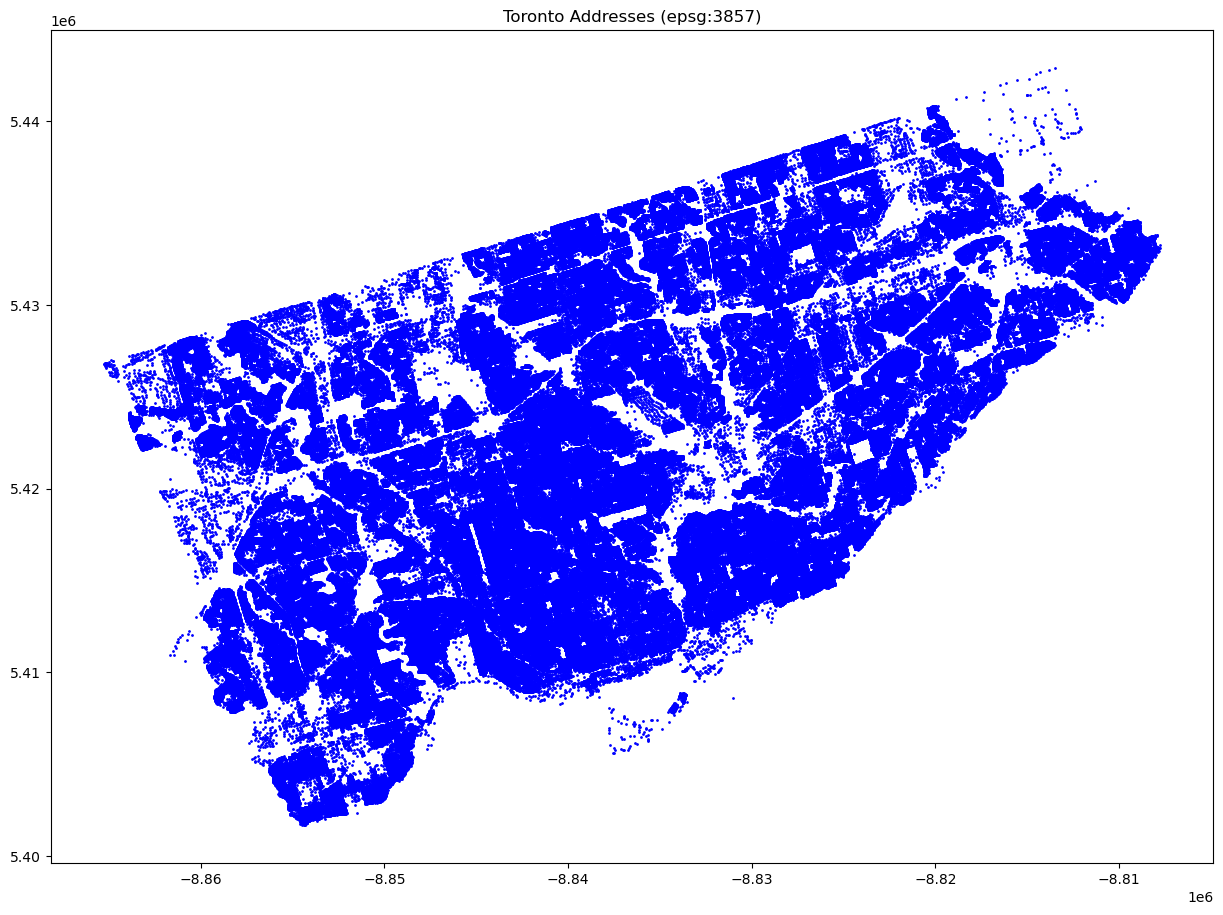

In [22]:
# What it looks like with original CRS
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Toronto Addresses (epsg:3857)')
plt.show()

In [23]:
# reprojecting epsg 3857 to epsg 4326
address = address.to_crs({'init': 'epsg:2019'})

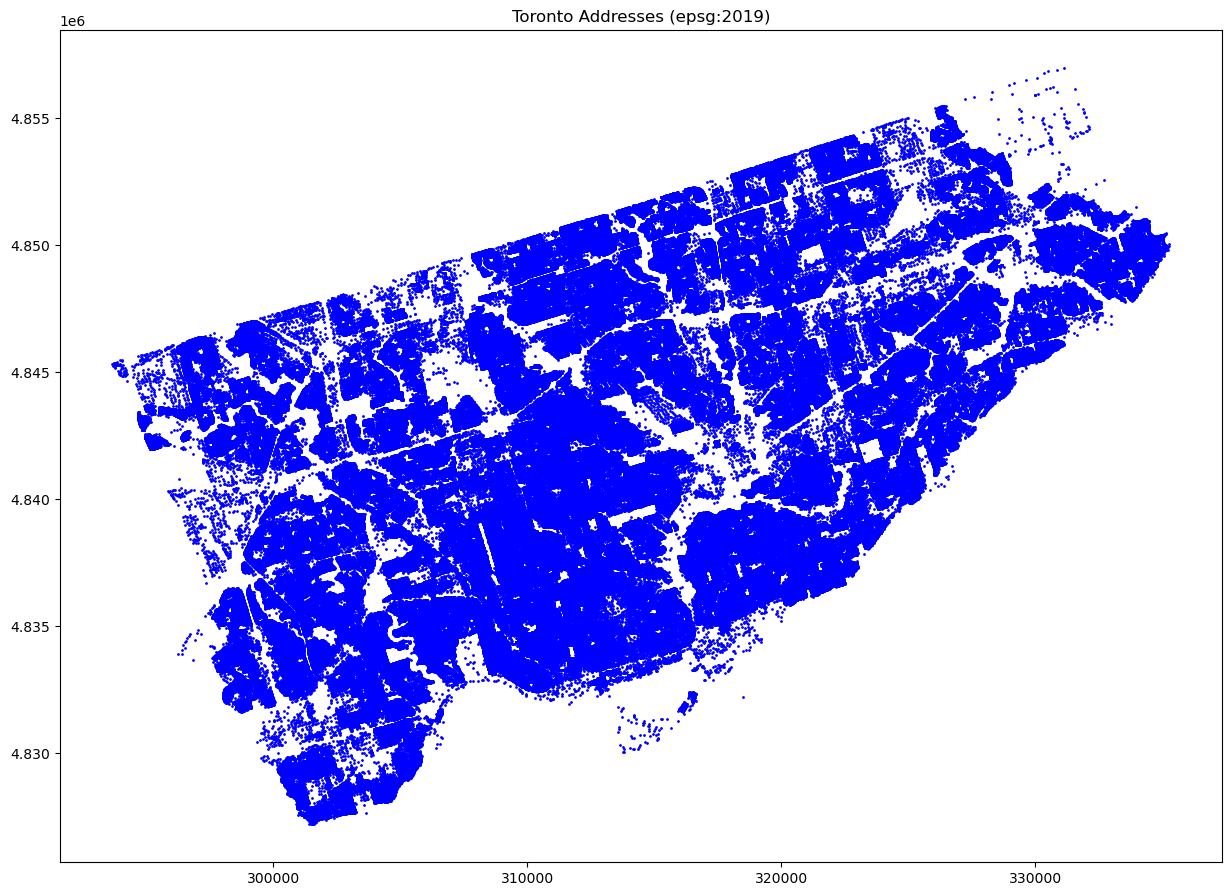

In [24]:
# What it looks like post transformation
# They look pretty much the same. Regardless, we will continue to reproject everything to epsg:2019 for consistency
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Toronto Addresses (epsg:2019)')
plt.show()

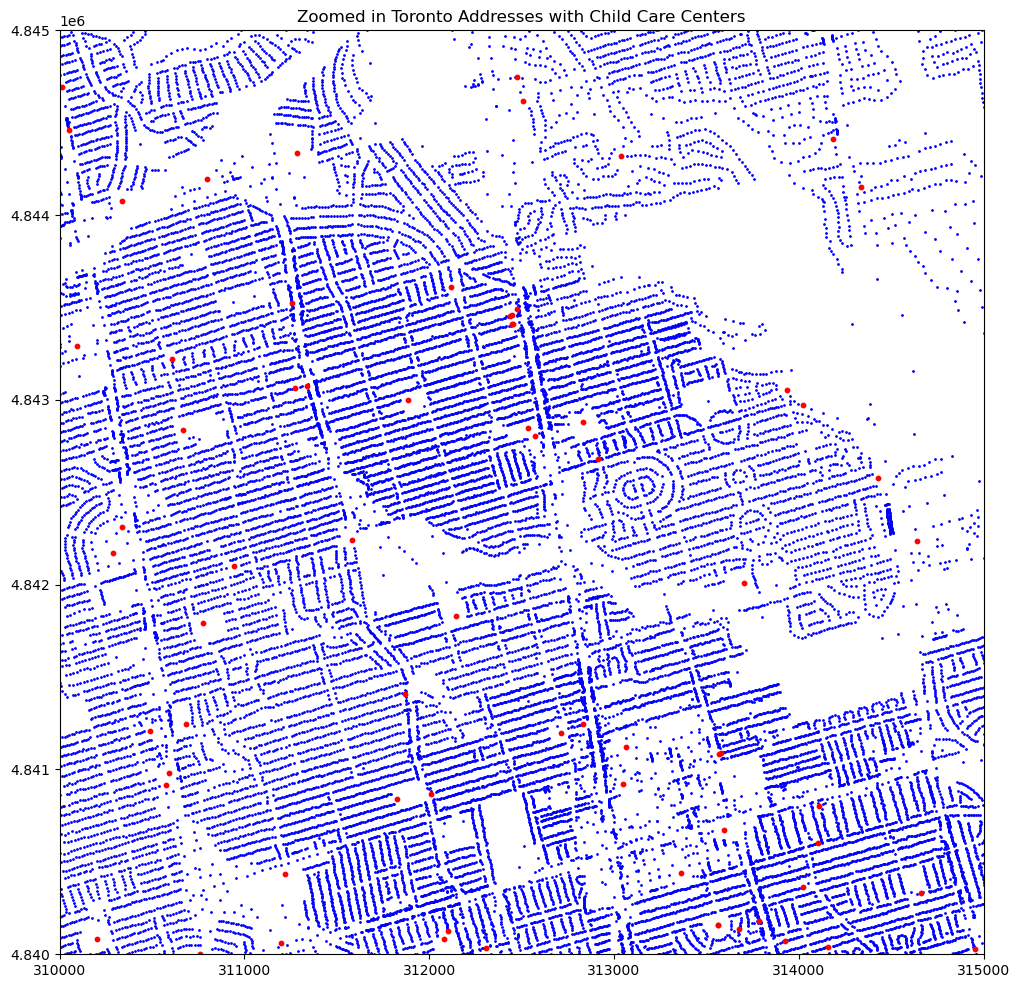

In [25]:
# Check out a zoomed in portion of the addresses with child care centers layered on
ax = address.plot(figsize=(12, 12),color='blue', markersize =1)
child_care.plot(ax=ax,color='red', markersize =10)
ax.set(xlim=(310000, 315000), ylim=(4840000, 4845000))
ax.set_title('Zoomed in Toronto Addresses with Child Care Centers')
plt.show()

### Wellbeing Youth Health Services

In [26]:
youth_health = gpd.read_file('raw_data/Health Services.shp')
youth_health.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,...,FIELD_16,FIELD_17,FIELD_18,FIELD_19,FIELD_20,FIELD_21,FIELD_22,FIELD_23,FIELD_24,geometry
0,1,800,Rouge Valley Health System,"2867 Ellesmere Rd, Toronto, ON M1E 4B9","Morningside, 135",416-284-8131,patientrelations@rougevalley.ca,"<a href=""http://www.rougevalley.ca"" target=""_b...",None,Acute care hospital * complex continuing care ...,...,2015-12-30T05:00:00,6362828,None,None,None,None,2867 Ellesmere Rd,Scarborough,M1E 4B9,POINT (-79.20496 43.78008)
1,2,801,"University Health Network, Toronto Rehabilitat...","130 Dunn Ave, Toronto, ON M6K 2R7","South Parkdale, 85",416-597-3422 ext 2000 ; 416-59-REHAB ext 2000,None,"<a href=""http://www.uhn.ca/torontorehab"" targe...",None,Complex continuing care facility * outpatient ...,...,2014-01-16T05:00:00,8168605,None,None,None,None,130 Dunn Ave,former Toronto,M6K 2R7,POINT (-79.43308 43.63500)
2,3,1003,Cliffcrest Health Centre,"2890 Kingston Rd, Toronto, ON M1M 1N5",None,416-267-2238,None,"<a href=""http://"" target=""_blank""></a>",No restrictions,"Offers dental and denture work, audiology serv...",...,2016-02-16T05:00:00,352165,None,None,None,None,2890 Kingston Rd,Scarborough,M1M 1N5,POINT (-79.23515 43.72323)
3,4,1004,Golden Care Dental Services,"1571 Sandhurst Circle, Scarborough, ON M1V...",None,416-484-6228,info@GoldenCareDentalServices.com,"<a href=""http://www.goldencaredentalservices.c...",seniors who are not mobile,Mobile dental services bringing services to pa...,...,2015-06-24T04:00:00,7531002,None,None,None,None,1571 Sandhurst Crcl,Scarborough,M1V 1V2,POINT (-79.26931 43.80922)
4,5,1005,"Toronto, City of","160 Burough Dr, Toronto, ON M1P 4N8",None,416-338-7442,None,"<a href=""http://www.toronto.ca/health/dental"" ...","Cannot afford to go to private dentist, 0-13 y...",The City of Toronto's Public Health Dental Cli...,...,2014-11-04T05:00:00,12697721,None,None,None,None,160 Borough Dr,Scarborough,M1P 4N8,POINT (-79.25648 43.77305)


In [27]:
# reprojecting to epsg 2019
youth_health = youth_health.to_crs({'init': 'epsg:2019'})

# Combine Dataframes

In [28]:
child_care.columns

Index(['_id', 'LOC_ID', 'LOC_NAME', 'ADDRESS', 'geometry', 'x', 'y'], dtype='object')

In [29]:
schools.columns

Index(['_id', 'objectid', 'tcdsb_code', 'sch_name', 'address_full',
       'municipality', 'postal_code', 'tcdsb_level', 'status', 'geometry'],
      dtype='object')

In [30]:
# Merge dataframes by including new column "point_of_interest," and removing all other columns besides geometry
child_care['point_of_interest'] = 'Child Care Center'
schools['point_of_interest'] = 'School'
youth_health['point_of_interest'] = 'Youth Health Service'


frames = [child_care[['geometry', 'point_of_interest']], schools[['geometry', 'point_of_interest']], 
          youth_health[['geometry', 'point_of_interest']]]
merged = pd.concat(frames)
# Also add x and y columns (from each coordinate pair)
merged['x'] = merged['geometry'].x
merged['y'] = merged['geometry'].y
merged.sample(10)

,geometry,point_of_interest,x,y
96,POINT (316380.094 4843469.362),School,316380.094190,4.843469e+06
807,POINT (314107.338 4840802.347),Child Care Center,314107.337879,4.840802e+06
962,POINT (313357.028 4834201.001),Child Care Center,313357.027864,4.834201e+06
1,POINT (302610.050 4838192.207),School,302610.050246,4.838192e+06
96,POINT (323819.061 4845442.137),Child Care Center,323819.060658,4.845442e+06
32,POINT (315600.835 4839782.130),Child Care Center,315600.834688,4.839782e+06
784,POINT (308019.863 4835627.561),Child Care Center,308019.863068,4.835628e+06
874,POINT (309644.314 4838800.485),Child Care Center,309644.313591,4.838800e+06
69,POINT (316251.318 4848779.205),Child Care Center,316251.317631,4.848779e+06
162,POINT (306214.740 4843247.289),Child Care Center,306214.740069,4.843247e+06


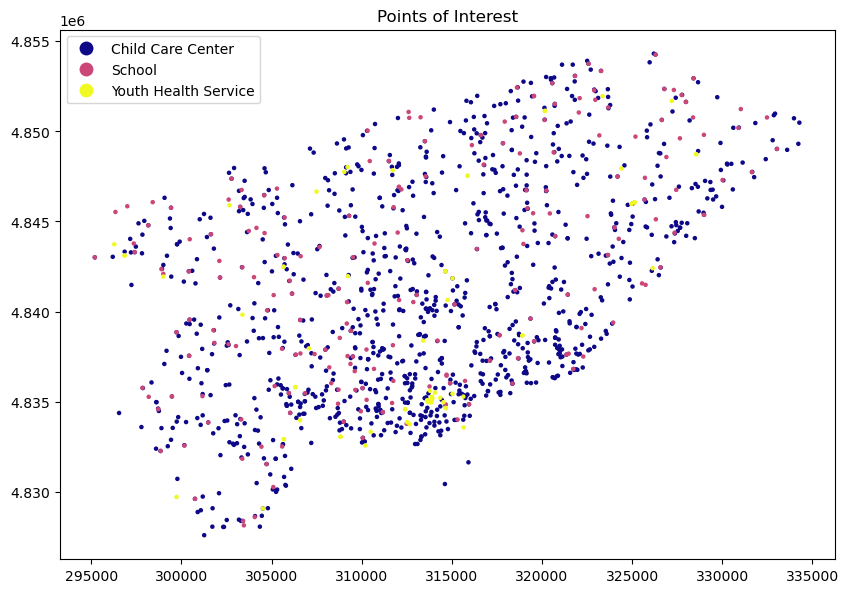

In [31]:
# Plot the points of interest
ax = merged.plot(column = 'point_of_interest', figsize=(10, 10), markersize = 5, legend = True, cmap = 'plasma')
ax.set_title('Points of Interest')
plt.show()

In [32]:
merged.to_file("merged.shp")

# Read in the Pednet data. 

The Pedestrian Network (pednet) was created by the DAV team at the City of Toronto, and it is based on the sidewalk inventory from Transportation Services, Toronto road centrelines, and manual collection from aerial imagery. Pednet is integrated with centerline intersections, traffic signals, pedestrian crosswalks and crossovers, traffic signal data from Transportation Services as well as other City of Toronto datasets. https://open.toronto.ca/dataset/pedestrian-network/

We need the Pednet data here to be the lines that connect our nodes (the child care centers).

In [33]:
pednet = gpd.read_file('raw_data/Pedestrian Network Data.shp')
pednet = pednet.to_crs({'init': 'epsg:2019'})
pednet.crs

{'init': 'epsg:2019'}

In [34]:
pednet.head()

,FIELD_1,FIELD_2,FIELD_3,FIELD_4,FIELD_5,FIELD_6,FIELD_7,FIELD_8,FIELD_9,FIELD_10,FIELD_11,geometry
0,696841,1,Local,7,Sidewalk on both sides,0,None,NaN,None,93.867680,129.824322,"LINESTRING (299647.480 4843993.305, 299730.645..."
1,696842,2,Collector,7,Sidewalk on both sides,0,None,NaN,None,32.546284,44.903807,"LINESTRING (299319.487 4832701.797, 299351.915..."
2,696843,3,None,2,Sidewalk on north side only,0,None,NaN,None,117.669206,162.522572,"LINESTRING (314644.016 4837403.152, 314756.028..."
3,696844,4,None,7,Sidewalk on both sides,0,None,NaN,None,223.269710,309.035596,"LINESTRING (303307.301 4840346.899, 303450.851..."
4,696845,5,Local,7,Sidewalk on both sides,0,None,NaN,None,201.335648,278.478601,"LINESTRING (320802.305 4848122.923, 320996.750..."


In [35]:
# Replace uninformative column names with correct column titles taken from the above link
pednet_column_names = ['_id', 'OBJECTID', 'ROAD_TYPE', 'SIDEWALK_CODE', 'SIDEWALK_DESCRIPTION', 'CROSSWALK', 'CROSSWALK_TYPE', 
                       'PX', 'PX_TYPE', 'LENGTH', 'Shape__Length', 'geometry']
mapper = dict(zip(list(pednet.columns), pednet_column_names))
pednet.rename(mapper = mapper, axis = 1, inplace = True)
pednet.head()

,_id,OBJECTID,ROAD_TYPE,SIDEWALK_CODE,SIDEWALK_DESCRIPTION,CROSSWALK,CROSSWALK_TYPE,PX,PX_TYPE,LENGTH,Shape__Length,geometry
0,696841,1,Local,7,Sidewalk on both sides,0,None,NaN,None,93.867680,129.824322,"LINESTRING (299647.480 4843993.305, 299730.645..."
1,696842,2,Collector,7,Sidewalk on both sides,0,None,NaN,None,32.546284,44.903807,"LINESTRING (299319.487 4832701.797, 299351.915..."
2,696843,3,None,2,Sidewalk on north side only,0,None,NaN,None,117.669206,162.522572,"LINESTRING (314644.016 4837403.152, 314756.028..."
3,696844,4,None,7,Sidewalk on both sides,0,None,NaN,None,223.269710,309.035596,"LINESTRING (303307.301 4840346.899, 303450.851..."
4,696845,5,Local,7,Sidewalk on both sides,0,None,NaN,None,201.335648,278.478601,"LINESTRING (320802.305 4848122.923, 320996.750..."


In [63]:
pednet.sidewalk_description.unique()

array(['Sidewalk on both sides', 'Sidewalk on north side only',
       'Not applicable', None, 'Laneway without any sidewalks',
       'No sidewalk on either side', 'City walkway',
       'Sidewalk on west side only', 'Sidewalk on south side only',
       'Sidewalk on east side only',
       'Sidewalk on east side; partially on other side',
       'Recreational Trail',
       'Sidewalk on west side; partially on other side',
       'Laneway with at least partial sidewalk on one side',
       'Partial sidewalk on at least one side',
       'Laneway with sidewalk on east side',
       'Roadway under development; some sidewalk present',
       'Roadway under development', 'No Sidewalk on either side',
       'Laneway with sidewalk on west side',
       'Sidewalk on south side; partially on other side',
       'Laneway with sidewalk on both sides',
       'Sidewalk on north side; partially on other side',
       'Not applicable; may be outdated'], dtype=object)

In [36]:
# Check missing values
len(pednet), pednet.isna().sum()

(87105,
 _id                         0
 OBJECTID                    0
 ROAD_TYPE                 790
 SIDEWALK_CODE               0
 SIDEWALK_DESCRIPTION     2696
 CROSSWALK                   0
 CROSSWALK_TYPE          77797
 PX                      79479
 PX_TYPE                 79479
 LENGTH                      0
 Shape__Length               0
 geometry                    0
 dtype: int64)

In [37]:
# Drop the columns with over 70k missing values
# Drop other irrelevant columns
pednet.drop(columns = ['CROSSWALK_TYPE', 'PX', 'PX_TYPE', 'SIDEWALK_CODE', 'LENGTH'], inplace = True)
# Rename columns to all be lower case
pednet.columns = map(str.lower, pednet.columns)
pednet.head()

,_id,objectid,road_type,sidewalk_description,crosswalk,shape__length,geometry
0,696841,1,Local,Sidewalk on both sides,0,129.824322,"LINESTRING (299647.480 4843993.305, 299730.645..."
1,696842,2,Collector,Sidewalk on both sides,0,44.903807,"LINESTRING (299319.487 4832701.797, 299351.915..."
2,696843,3,None,Sidewalk on north side only,0,162.522572,"LINESTRING (314644.016 4837403.152, 314756.028..."
3,696844,4,None,Sidewalk on both sides,0,309.035596,"LINESTRING (303307.301 4840346.899, 303450.851..."
4,696845,5,Local,Sidewalk on both sides,0,278.478601,"LINESTRING (320802.305 4848122.923, 320996.750..."


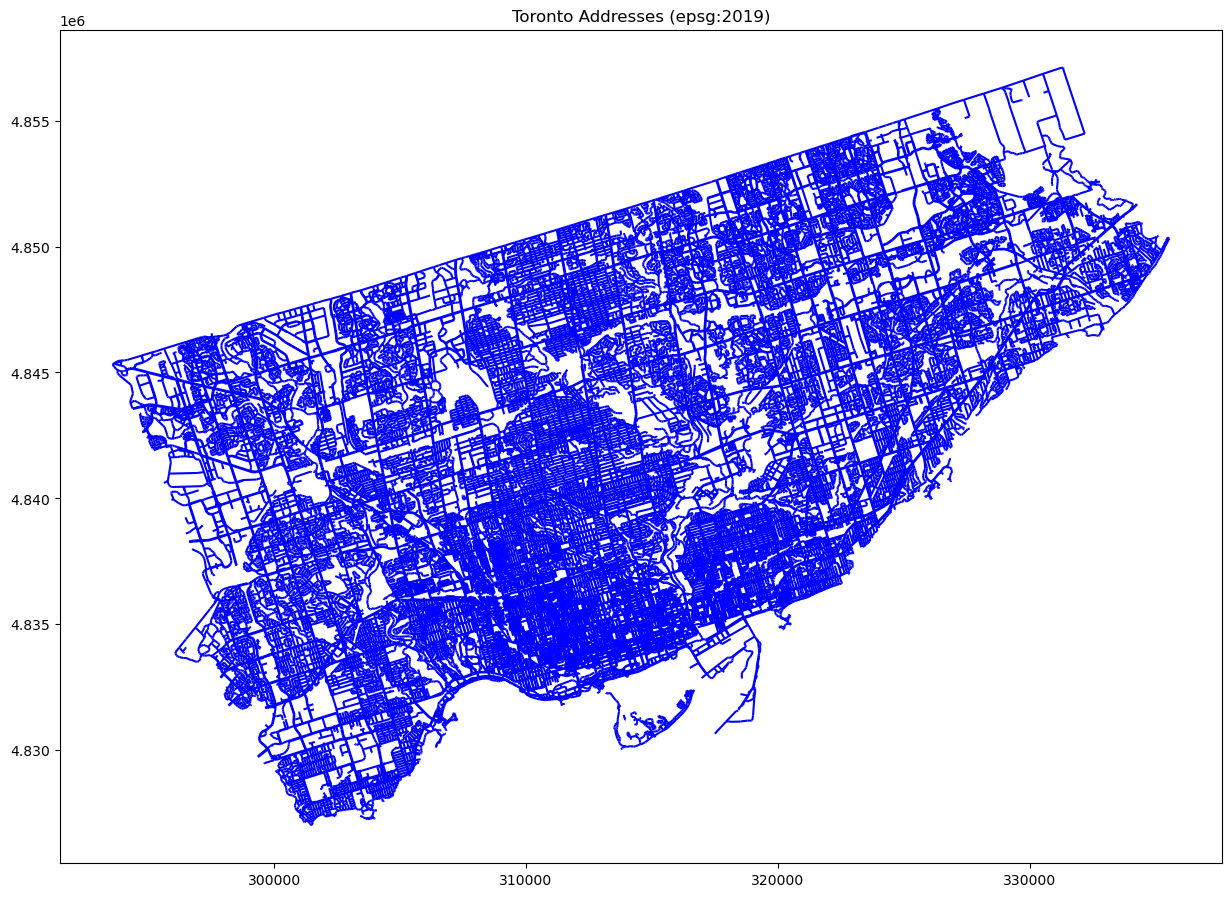

In [38]:
# Look at the pednet plot
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)
ax.set_title('Toronto Addresses (epsg:2019)')
plt.show()

### Bring in Function to Facilitate Distance Calculations

In [39]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

In [40]:
graph = create_graph(pednet)

In [41]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(graph,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)

In [42]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges.head(3)

,from,to,shape__length,sidewalk_description,geometry,length,road_type,crosswalk,forward,_id,visited,objectid,to_node,from_node
0,"(299647.48, 4843993.305)","(299730.645, 4843949.766)",129.824322,Sidewalk on both sides,LINESTRING (299647.4801773648 4843993.30454858...,93.871829,Local,0,1,696841,0,1,31303,60732
1,"(299647.48, 4843993.305)","(299602.64, 4844063.116)",114.951163,Sidewalk on both sides,LINESTRING (299602.6398887987 4844063.11581879...,82.971471,Local,0,1,780939,0,84099,5980,60732
2,"(299730.645, 4843949.766)","(299811.934, 4843907.77)",126.536247,No sidewalk on either side,LINESTRING (299730.6445645975 4843949.76600211...,91.496355,Local,0,1,722552,0,25712,35031,31303


In [43]:
ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

In [44]:
#precompute a given horizon distance of 1000 meters
ped_net.precompute(1000)
ped_net.edges_df.head(2)

,from,to,length
0,60732,31303,93.871829
1,60732,5980,82.971471


In [45]:
#get node_ids for points for each layer
x, y = merged['geometry'].x, merged['geometry'].y 
merged["node_ids"] = ped_net.get_node_ids(x, y)
ped_net.set(merged["node_ids"], name="destination")

# using x and y coordinates from address that are utm nad27 
x, y = address.x, address.y
address["node_ids"] = ped_net.get_node_ids(x, y)

In [46]:
address.head()

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,ward_name,geometry,node_ids
0,5729529,REGULAR,399,Lake Promenade,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,Etobicoke-Lakeshore,POINT (301607.060 4827228.149),59760
1,9950585,REGULAR,7,Hilo Rd,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,Etobicoke-Lakeshore,POINT (301539.918 4827377.205),61597
2,5729496,REGULAR,387,Lake Promenade,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,Etobicoke-Lakeshore,POINT (301648.398 4827256.282),59760
3,5729341,REGULAR,321,Lake Promenade,301926.249,4827620.088,-79.535591,43.588517,1491594.0,Etobicoke,Etobicoke-Lakeshore,POINT (301926.167 4827404.304),26780
4,7304577,REGULAR,22,Thirty Sixth St,301937.384,4827737.920,-79.535454,43.589578,1491597.0,Etobicoke,Etobicoke-Lakeshore,POINT (301937.302 4827522.134),57942


In [47]:
#get nearest points with id
n=10
maxdistance = 5000

ped_net.set_pois("destination", maxdistance , n, merged['geometry'].x, merged['geometry'].y)
walk_distances = ped_net.nearest_pois(maxdistance , "destination", num_pois=n, include_poi_ids=False)

walk_distances.head(3)

,1,2,3,4,5,6,7,8,9,10
0,1494.072021,1494.072021,1517.104004,1545.187988,1587.051025,1596.000977,1723.125977,1837.271973,1879.307983,1890.005005
1,506.835999,506.835999,946.799988,946.799988,1217.880981,1274.965942,1278.350952,1335.120972,1429.837036,1469.095947
2,394.247986,723.539001,723.539001,738.403015,900.098999,900.098999,1270.192993,1437.305054,1540.775024,1713.322021


In [48]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['destination'+str(i) for i in range(0,n,1)]

walk_distances.columns = columns
walk_distances.head(2)

,destination0,destination1,destination2,destination3,destination4,destination5,destination6,destination7,destination8,destination9
0,1494.072021,1494.072021,1517.104004,1545.187988,1587.051025,1596.000977,1723.125977,1837.271973,1879.307983,1890.005005
1,506.835999,506.835999,946.799988,946.799988,1217.880981,1274.965942,1278.350952,1335.120972,1429.837036,1469.095947


In [49]:
for i in range(10):
    address['destination_distance{}'.format(i)]=address['node_ids'].map(walk_distances['destination{}'.format(i)])
address.head(3)

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,...,destination_distance0,destination_distance1,destination_distance2,destination_distance3,destination_distance4,destination_distance5,destination_distance6,destination_distance7,destination_distance8,destination_distance9
0,5729529,REGULAR,399,Lake Promenade,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,...,525.765991,805.987976,1215.489014,1518.217041,1788.779053,1888.009033,2183.667969,2301.128906,2309.674072,2394.002930
1,9950585,REGULAR,7,Hilo Rd,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,...,414.541992,615.520020,1025.020996,1327.749023,1598.311035,1697.541016,1993.199951,2110.660889,2119.206055,2203.534912
2,5729496,REGULAR,387,Lake Promenade,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,...,525.765991,805.987976,1215.489014,1518.217041,1788.779053,1888.009033,2183.667969,2301.128906,2309.674072,2394.002930


In [50]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

address['m_destination_distance0'] = address.apply(lambda row: row.destination_distance0/(1.2*60), axis=1)
address['m_destination_distance1'] = address.apply(lambda row: row.destination_distance1/(1.2*60), axis=1)
address['m_destination_distance2'] = address.apply(lambda row: row.destination_distance2/(1.2*60), axis=1)
address['m_destination_distance3'] = address.apply(lambda row: row.destination_distance3/(1.2*60), axis=1)
address['m_destination_distance4'] = address.apply(lambda row: row.destination_distance4/(1.2*60), axis=1)
address['m_destination_distance5'] = address.apply(lambda row: row.destination_distance5/(1.2*60), axis=1)
address['m_destination_distance6'] = address.apply(lambda row: row.destination_distance6/(1.2*60), axis=1)
address['m_destination_distance7'] = address.apply(lambda row: row.destination_distance7/(1.2*60), axis=1)
address['m_destination_distance8'] = address.apply(lambda row: row.destination_distance8/(1.2*60), axis=1)
address['m_destination_distance9'] = address.apply(lambda row: row.destination_distance9/(1.2*60), axis=1)
address.head(3)

,geo_id,maint_stag,address,lfname,x,y,longitude,latitude,objectid,mun_name,...,m_destination_distance0,m_destination_distance1,m_destination_distance2,m_destination_distance3,m_destination_distance4,m_destination_distance5,m_destination_distance6,m_destination_distance7,m_destination_distance8,m_destination_distance9
0,5729529,REGULAR,399,Lake Promenade,301607.151,4827443.931,-79.539542,43.586930,1491585.0,Etobicoke,...,7.302305,11.194277,16.881792,21.086348,24.844154,26.222348,30.328722,31.960124,32.078807,33.250041
1,9950585,REGULAR,7,Hilo Rd,301540.011,4827592.989,-79.540374,43.588272,1491586.0,Etobicoke,...,5.757528,8.548889,14.236403,18.440959,22.198764,23.576959,27.683333,29.314735,29.433417,30.604652
2,5729496,REGULAR,387,Lake Promenade,301648.488,4827472.065,-79.539030,43.587184,1491591.0,Etobicoke,...,7.302305,11.194277,16.881792,21.086348,24.844154,26.222348,30.328722,31.960124,32.078807,33.250041


In [51]:
address.columns

Index(['geo_id', 'maint_stag', 'address', 'lfname', 'x', 'y', 'longitude',
       'latitude', 'objectid', 'mun_name', 'ward_name', 'geometry', 'node_ids',
       'destination_distance0', 'destination_distance1',
       'destination_distance2', 'destination_distance3',
       'destination_distance4', 'destination_distance5',
       'destination_distance6', 'destination_distance7',
       'destination_distance8', 'destination_distance9',
       'm_destination_distance0', 'm_destination_distance1',
       'm_destination_distance2', 'm_destination_distance3',
       'm_destination_distance4', 'm_destination_distance5',
       'm_destination_distance6', 'm_destination_distance7',
       'm_destination_distance8', 'm_destination_distance9'],
      dtype='object')

In [60]:
address[['destination_distance0', 'm_destination_distance0']].sort_values(by = ['destination_distance0', 'm_destination_distance0'],
                                                                         ascending = False)

,destination_distance0,m_destination_distance0
11919,5000.0,69.444444
14080,5000.0,69.444444
14163,5000.0,69.444444
14298,5000.0,69.444444
14319,5000.0,69.444444
...,...,...
525437,0.0,0.000000
525438,0.0,0.000000
525439,0.0,0.000000
525440,0.0,0.000000


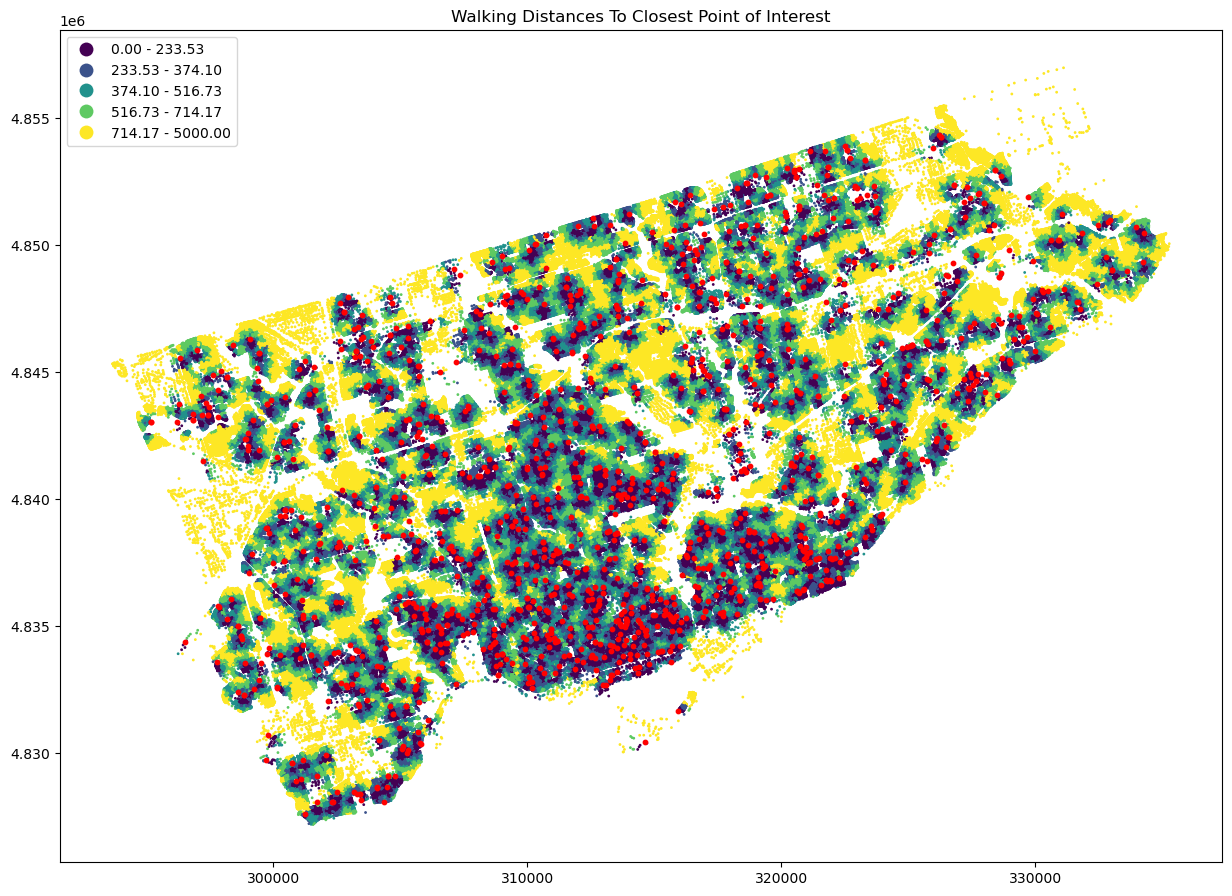

In [61]:
# Walking times To closest point of interest

ax = address.plot(figsize=(15, 15), column='destination_distance0', scheme='quantiles', legend=True,markersize = 1)
merged.plot(ax=ax, color='red', markersize =10)
plt.title('Walking Distances To Closest Point of Interest')
plt.show()